# import

In [24]:
# В этой среде Python 3 установлено множество полезных аналитических библиотек.
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import re
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# Файлы входных данных доступны в каталоге "../input/".
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# Например, при выполнении этого (нажав кнопку Выполнить или нажав клавишу Shift+Ввод)
# будет выведен список всех файлов в каталоге ввода

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
# Любые результаты, которые вы записываете в текущий каталог, сохраняются как выходные данные.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
#DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
#функции обработки

#считаем % пропусков по каждому признаку
#функция missing_data(data) будет принимать на вход датасет, и определять % пропусков и тип данных
def missing_data(data):
    for i in data.columns:
        md = 100-data[i].isna().value_counts()[0]*100/len(data[i])
        print('% пропусков в',i, md)
    return

#функция которая получает на вход серию со списком всех кухонь и убирает аартефакты в названиях,
#формируя список 
def resplit(ct):
    ct = ct.replace(", ",'')
    ct = ct.replace("[",'')
    ct = ct.replace("]",'')
    ct = re.split("'(.*?)'",ct)
    ct = list(filter(None, ct))
    return ct

#простая функция длинны списка
def len_list(data):
    return len(data)


# функиця разделения даты из отзывов
# тип данных строка, визуально похожая на списки
# необходимо разпарсить данные
# кроме того , в строке есть дата отзыва, ее тоже надо достать
# кол-во дат будет равно кол-ву отзывов


def split_date(ct):
    if re.findall(r'\d\d/\d\d/\d{4}', ct) == 'None':
        return dt.datetime(1900,12,31)
    else:
        return  re.findall(r'\d\d/\d\d/\d{4}', ct)
    
# функция возвращает разницу между первым и последним отзывом в формате datetime
def deltadays(rd):
    if len(rd)>=2:
        a = dt.datetime.strptime(rd[0], '%m/%d/%Y') - dt.datetime.strptime(rd[len(rd)-1], '%m/%d/%Y')
        return a
    else:
        return dt.timedelta(0)

**Посчитаем процент пропусков в базовом датасете.**

In [7]:
missing_data(data)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.180000000000007
% пропусков в Ranking 0.0
% пропусков в Price Range 34.721999999999994
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0


# feature engineering

## Обработаем города и создадим новые признаки.

In [9]:
#признак Столица - capital

#импортируем данные по городам мира, и заберем оттуда только столицы (признак primary)
cities = pd.read_csv('worldcities.csv') #публичный датасет по городам мира
cities = cities[cities['capital']=='primary']
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140
7,Seoul,Seoul,37.5600,126.9900,"Korea, South",KR,KOR,Seoul,primary,21794000.0,1410836482
8,Mexico City,Mexico City,19.4333,-99.1333,Mexico,MX,MEX,Ciudad de México,primary,20996000.0,1484247881


In [10]:
#уберем ненужную информацию и сформируем список столиц мира, хотя нам надо только европу, но все же
cities.drop(['city_ascii', 'lat','lng','capital','id','admin_name'], inplace=True, axis=1)
cities_list=list(cities['city'])

In [11]:
#вводим новый признак Столица, 1 если город столичный, 0 если не столичный
data['capital']=data['City'].apply(lambda x: 1 if x in cities_list else 0 )

In [12]:
data.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1


### Признак население - population.

In [13]:
#получаем список городов
city_list=data['City'].unique()

In [14]:
#попробуем добавить численность населения
city_list={'Paris':2.148, 'Stockholm':0.975, 'London':8.961, 'Berlin':3.669, 'Munich':1.488, 'Oporto':0.287,
       'Milan':1.1399, 'Bratislava':0.428, 'Vienna':1.921, 'Rome':2.790, 'Barcelona':1.664, 'Madrid':3.334,
       'Dublin':1.173, 'Brussels':1.212, 'Zurich':0.434, 'Warsaw':1.793, 'Budapest':1.750, 'Copenhagen':0.794,
       'Amsterdam':0.860, 'Lyon':0.518, 'Hamburg':1.845, 'Lisbon':0.506, 'Prague':1.335, 'Oslo':0.693,
       'Helsinki':0.655, 'Edinburgh':0.488, 'Geneva':0.201, 'Ljubljana':0.286, 'Athens':0.664,
       'Luxembourg':0.644, 'Krakow':0.779}
data['population'] = data['City'].replace(to_replace=city_list)

In [15]:
data.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,population
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,2.148


**Приведем переменную Price Range к числовому виду и заменим пропуски модальным значением.**

In [16]:
range_replace={'$':1, '$$ - $$$':2, '$$$$':3}
#price_cat(data['Price Range'])
#data['Price Range']=data['Price Range'].apply(lambda x: 1 if x=='$' (elif 2 if x=='$$ - $$$' (elif 3 if x=='$$$$')))
data['Price Range']=data['Price Range'].replace(to_replace=range_replace)
data['Price Range'].unique()

array([ 2.,  3.,  1., nan])

In [17]:
#узнаем модальное значение для категории Price Range которым позже заполним пропуски
print('Модальное значение для категории Price Range',data['Price Range'].mode()[0])

Модальное значение для категории Price Range 2.0


In [18]:
#заменим пропуски модальным значением
data['Price Range'].fillna(2, inplace=True, axis=0)

In [19]:
#проверяем пропуски
missing_data(data)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.180000000000007
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0


**Добавим признак цены в городе.**

In [20]:
price_in_city_dict = data.groupby('City')['Price Range'].mean().to_dict()
data['Price in City'] = data['City'].map(price_in_city_dict)
data.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,population,Price in City
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,2.148,1.926981


**Проверим данные по дате отзывов и временной дельте.**

In [21]:
data['Reviews'].fillna('',inplace=True)
data['rev_date'] = data['Reviews'].apply(split_date)
data['rev_date']

0                              []
1        [12/05/2017, 10/29/2017]
2        [12/28/2017, 12/06/2017]
3        [12/06/2017, 11/22/2017]
4        [02/08/2018, 01/24/2018]
                   ...           
49995    [12/16/2017, 11/12/2017]
49996    [12/21/2017, 12/12/2017]
49997    [11/03/2016, 04/12/2008]
49998    [07/11/2017, 06/18/2017]
49999    [01/31/2016, 07/04/2012]
Name: rev_date, Length: 50000, dtype: object

**Создадим новый признак, кол-во отзывов,  применим функцию считающую длину списка с датами.**

In [22]:
data['col_r']=data['rev_date'].apply(len_list)
data['col_r'].unique()

array([0, 2, 1], dtype=int64)

**Посчитали разницу между отзывами для всех ресторанов.**

In [25]:
data['time_delta'] = data['rev_date'].apply(deltadays)
data['time_delta']

0          0 days
1         37 days
2         22 days
3         14 days
4         15 days
           ...   
49995     34 days
49996      9 days
49997   3127 days
49998     23 days
49999   1306 days
Name: time_delta, Length: 50000, dtype: timedelta64[ns]

In [26]:
data['reviews_date'] = data['rev_date']

**Новый признак hr - holiday review - сделан ли отзыв в праздники новый год.**

In [27]:
pattern = re.compile('\'\d+\/\d+\/\d+\'?')
data['reviews_date'] = data['Reviews'].apply(lambda x: pattern.findall(str(x)))
data['reviews_date']

0                                  []
1        ['12/05/2017', '10/29/2017']
2        ['12/28/2017', '12/06/2017']
3        ['12/06/2017', '11/22/2017']
4        ['02/08/2018', '01/24/2018']
                     ...             
49995    ['12/16/2017', '11/12/2017']
49996    ['12/21/2017', '12/12/2017']
49997    ['11/03/2016', '04/12/2008']
49998    ['07/11/2017', '06/18/2017']
49999    ['01/31/2016', '07/04/2012']
Name: reviews_date, Length: 50000, dtype: object

In [28]:
def holiday(data):
    b=0
    if data == '[]':
        return 0
    else:
        for i in range(0,len(data)-1):
            a = pd.to_datetime(re.findall(r'\d\d/\d\d/\d{4}', data[i]), format='%m/%d/%Y')
            if (a.month == 12 and a.day > 15) or (a.month == 1 and a.day < 15):
                b=1
                return 1
            else:
                if b == 1:
                    return
                else:
                    return 0

In [29]:
data['holiday'] = data['reviews_date'].apply(holiday)
data['holiday']

0        NaN
1        0.0
2        1.0
3        0.0
4        0.0
        ... 
49995    1.0
49996    1.0
49997    0.0
49998    0.0
49999    0.0
Name: holiday, Length: 50000, dtype: float64

In [30]:
data['holiday'].fillna(0, inplace=True)

data.drop(['reviews_date','rev_date'], axis=1 , inplace=True)
data.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,population,Price in City,col_r,time_delta,holiday
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,2.148,1.926981,0,0 days,0.0


**Уберем пропуски в Cuisine Style.**

In [31]:
#Это данные внешнего парсинга сайта tripadvisor
#т.к. scraping занимает много времени, его провели отдельным проектом, а здесь только импортируем результаты
#что бы сократить время
cuisine = pd.read_csv('cuisine.csv')
cuisine.head()

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [32]:
missing_data(cuisine)

% пропусков в Unnamed: 0 0.0
% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 0.0
% пропусков в Ranking 0.0
% пропусков в Price Range 34.721999999999994
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0


In [33]:
#видим что удалось убрать пропуски в признаке Cuisine Style
#теперь заменим данные на данные парсинга и сразу посчитаем кол-во кухонь в ресторане создав новый признак

#применяем функцию, которая создает списки кухонь в признаке без артефактов в строковых значениях.
data['Cuisine Style'] = cuisine['Cuisine Style'].apply(resplit)

**Признак col-cuisine - кол-во кухонь в ресторане.**

In [34]:
#считаем кол-во кухонь в каждом ресторане
data['col_cuisine'] = data['Cuisine Style'].apply(len_list)

**Добавим признак соотношения кол-ва кухонь в ресторане к макс кол-ву кухонь в городе.**

In [35]:
dict_ = pd.DataFrame(data.groupby('City')['Cuisine Style'].agg('sum'))
dict_['city_col_cuisine']=0
dict_

,Cuisine Style,city_col_cuisine
City,,
Amsterdam,"[Dutch, European, Vegetarian Friendly, Vegan O...",0
Athens,"[Greek, Greek, Mediterranean, European, Greek,...",0
Barcelona,"[Mediterranean, Spanish, Vegetarian Friendly, ...",0
Berlin,"[Bar, Pub, Cafe, German, Italian, Pizza, Vietn...",0
Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",0
Brussels,"[Italian, Mediterranean, Pizza, Moroccan, Medi...",0
Budapest,"[Italian, Pizza, Street Food, Hungarian, Cafe,...",0
Copenhagen,"[European, Scandinavian, Danish, Italian, Pizz...",0
Dublin,"[Italian, Pizza, European, Gluten Free Options...",0


In [36]:
#импортируем нужные библиотеки для подсчета уникальных элементов в списке
from  more_itertools import unique_everseen

In [37]:
#считаем кол-во уникальных кухонь в каждом городе

for i in range(0,len(dict_)):
    dict_['city_col_cuisine'][i]=len(list(unique_everseen(dict_['Cuisine Style'][i])))

dict_a = pd.DataFrame()

for i in range(0,len(dict_)):
    new_row = {'city':dict_.index[i], 'city_col_cuisine':dict_.values[i][1]} 
    dict_a = dict_a.append(new_row, ignore_index=True)

new_dict = dict_a.set_index('city').T.to_dict('list')
new_dict

<ipython-input-37-1ba67dcb9767>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_['city_col_cuisine'][i]=len(list(unique_everseen(dict_['Cuisine Style'][i])))


{'Amsterdam': [96.0],
 'Athens': [70.0],
 'Barcelona': [108.0],
 'Berlin': [108.0],
 'Bratislava': [63.0],
 'Brussels': [91.0],
 'Budapest': [81.0],
 'Copenhagen': [86.0],
 'Dublin': [78.0],
 'Edinburgh': [73.0],
 'Geneva': [67.0],
 'Hamburg': [85.0],
 'Helsinki': [80.0],
 'Krakow': [72.0],
 'Lisbon': [82.0],
 'Ljubljana': [57.0],
 'London': [120.0],
 'Luxembourg': [62.0],
 'Lyon': [87.0],
 'Madrid': [106.0],
 'Milan': [100.0],
 'Munich': [86.0],
 'Oporto': [57.0],
 'Oslo': [71.0],
 'Paris': [114.0],
 'Prague': [90.0],
 'Rome': [94.0],
 'Stockholm': [85.0],
 'Vienna': [97.0],
 'Warsaw': [81.0],
 'Zurich': [83.0]}

**Добавим новый признак 'city_col_cuisine' - кол-во типов кухонь в каждом городе.**

In [38]:
data['city_col_cuisine'] = data['City'].replace(to_replace=new_dict)
data.drop(['time_delta'], axis=1, inplace=True)

**Добавим новый признак, нормировка кухонь относительно каждого города.**

In [39]:
data['cuisine_norm'] = data['col_cuisine'] / data['city_col_cuisine']
data.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,population,Price in City,col_r,holiday,col_cuisine,city_col_cuisine,cuisine_norm
0,id_0,Paris,"[Bar, Pub]",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,2.148,1.926981,0,0.0,2,114.0,0.017544


**Создадим признак, кол-во ресторанов в городе.**

In [40]:
per_city_dict = data['City'].value_counts().to_dict()
per_city_dict

{'London': 7193,
 'Paris': 6108,
 'Madrid': 3813,
 'Barcelona': 3395,
 'Berlin': 2705,
 'Milan': 2694,
 'Rome': 2589,
 'Prague': 1816,
 'Lisbon': 1647,
 'Vienna': 1443,
 'Amsterdam': 1372,
 'Brussels': 1314,
 'Hamburg': 1186,
 'Munich': 1145,
 'Lyon': 1126,
 'Stockholm': 1033,
 'Budapest': 1021,
 'Warsaw': 925,
 'Dublin': 836,
 'Copenhagen': 819,
 'Athens': 776,
 'Edinburgh': 745,
 'Zurich': 685,
 'Oporto': 642,
 'Geneva': 590,
 'Krakow': 554,
 'Oslo': 488,
 'Helsinki': 475,
 'Bratislava': 380,
 'Luxembourg': 263,
 'Ljubljana': 222}

In [41]:
data['city_restaurants'] = data['City'].map(per_city_dict)
data['city_restaurants']

0        6108
1         475
2         745
3        7193
4         380
         ... 
49995    2694
49996    6108
49997    1033
49998     925
49999    2694
Name: city_restaurants, Length: 50000, dtype: int64

**Добавим признак - нормализованный ранг ranking_norm.**

In [42]:
data['ranking_norm'] = data['Ranking'] / data['city_restaurants']
data['ranking_norm']

0        2.122299
1        0.223158
2        1.087248
3        0.232031
4        0.097368
           ...   
49995    0.185598
49996    1.038147
49997    1.599226
49998    0.692973
49999    1.791759
Name: ranking_norm, Length: 50000, dtype: float64

In [43]:
missing_data(data)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 0.0
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
% пропусков в Price in City 0.0
% пропусков в col_r 0.0
% пропусков в holiday 0.0
% пропусков в col_cuisine 0.0
% пропусков в city_col_cuisine 0.0
% пропусков в cuisine_norm 0.0
% пропусков в city_restaurants 0.0
% пропусков в ranking_norm 0.0


**Добавим новый признак nor - среднее кол-во ресторанов в городе.**

In [45]:
#hist_outliers('Number of Reviews', 1000)

nor = data.groupby('City')['Number of Reviews'].mean().to_dict()
nor

{'Amsterdam': 148.74443591711434,
 'Athens': 93.9875173370319,
 'Barcelona': 135.6830963665087,
 'Berlin': 63.7721881390593,
 'Bratislava': 51.61609907120743,
 'Brussels': 92.64715447154471,
 'Budapest': 158.68021390374332,
 'Copenhagen': 95.05806451612904,
 'Dublin': 154.27638190954775,
 'Edinburgh': 237.71132596685084,
 'Geneva': 62.17335766423358,
 'Hamburg': 45.31818181818182,
 'Helsinki': 66.02013422818791,
 'Krakow': 130.56949806949808,
 'Lisbon': 127.830078125,
 'Ljubljana': 88.25603864734299,
 'London': 137.9683806146572,
 'Luxembourg': 83.268,
 'Lyon': 87.07321594068583,
 'Madrid': 99.91188811188812,
 'Milan': 168.29886851346077,
 'Munich': 77.64938737040528,
 'Oporto': 134.14858096828047,
 'Oslo': 100.00429184549357,
 'Paris': 117.04091456077016,
 'Prague': 124.37772246421905,
 'Rome': 289.7871070433745,
 'Stockholm': 75.19747899159664,
 'Vienna': 80.53509433962265,
 'Warsaw': 67.11218335343787,
 'Zurich': 72.51007751937985}

In [47]:
#добавили новый признак nor - среднее кол-во отзывов по городу
data['nor']=data['City'].replace(to_replace=nor)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      50000 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        50000 non-null  float64
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            50000 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  capital            50000 non-null  int64  
 12  population         50000 non-null  float64
 13  Price in City      50000 non-null  float64
 14  col_r              50000 non-null  int64  
 15  holiday            50000 non-null  float64
 16  col_cuisine        500

**Заполним пропуски в Number of Reviews.**

In [52]:
#узнаем модальное значение для категории Number of Reviews которым позже заполним пропуски
print('Модальное значение для категории Number of Reviews',data['Number of Reviews'].mode()[0])

Модальное значение для категории Number of Reviews 2.0


In [53]:
#заменим пропуски модальным значением
data['Number of Reviews'].fillna(2, inplace=True, axis=0)

In [54]:
missing_data(data)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 0.0
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 0.0
% пропусков в Reviews 0.0
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
% пропусков в Price in City 0.0
% пропусков в col_r 0.0
% пропусков в holiday 0.0
% пропусков в col_cuisine 0.0
% пропусков в city_col_cuisine 0.0
% пропусков в cuisine_norm 0.0
% пропусков в city_restaurants 0.0
% пропусков в ranking_norm 0.0
% пропусков в nor 0.0


**Преобразуем признак City с помощью get_dummies.**

In [55]:
data = pd.get_dummies(data, columns=['City'], dummy_na=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   Cuisine Style      50000 non-null  object 
 2   Ranking            50000 non-null  float64
 3   Price Range        50000 non-null  float64
 4   Number of Reviews  50000 non-null  float64
 5   Reviews            50000 non-null  object 
 6   URL_TA             50000 non-null  object 
 7   ID_TA              50000 non-null  object 
 8   sample             50000 non-null  int64  
 9   Rating             50000 non-null  float64
 10  capital            50000 non-null  int64  
 11  population         50000 non-null  float64
 12  Price in City      50000 non-null  float64
 13  col_r              50000 non-null  int64  
 14  holiday            50000 non-null  float64
 15  col_cuisine        50000 non-null  int64  
 16  city_col_cuisine   500

**Запускаем и проверяем что получилось.**

In [58]:
# Удаляем нечисловые данные.
data = data.drop(columns=['Restaurant_id','Cuisine Style','Reviews','URL_TA','ID_TA'])
data.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,capital,population,Price in City,col_r,holiday,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
38215,3587.0,2.0,38.0,1,4.0,0,1.6640,1.856259,2,0.0,...,0,0,0,0,0,0,0,0,0,0
26034,274.0,2.0,29.0,1,4.0,1,0.6440,1.984791,2,0.0,...,0,0,0,0,0,0,0,0,0,0
49330,4052.0,2.0,30.0,1,3.5,0,1.1399,1.845583,2,0.0,...,0,0,0,0,0,0,0,0,0,0
39305,5819.0,2.0,13.0,1,5.0,1,2.1480,1.926981,0,0.0,...,0,0,1,0,0,0,0,0,0,0
27259,8216.0,2.0,2.0,1,5.0,1,8.9610,1.861949,2,1.0,...,0,0,0,0,0,0,0,0,0,0
18477,7106.0,2.0,8.0,1,4.0,1,2.1480,1.926981,2,1.0,...,0,0,1,0,0,0,0,0,0,0
6145,1267.0,2.0,90.0,0,0.0,1,3.3340,1.916077,2,0.0,...,0,0,0,0,0,0,0,0,0,0
7357,1435.0,2.0,23.0,0,0.0,1,0.8600,1.871720,2,0.0,...,0,0,0,0,0,0,0,0,0,0
11378,973.0,2.0,543.0,1,4.0,1,2.1480,1.926981,2,1.0,...,0,0,1,0,0,0,0,0,0,0
47424,117.0,2.0,70.0,1,5.0,1,1.7500,1.807052,2,0.0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [61]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [62]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 47), (40000, 47), (40000, 46), (32000, 46), (8000, 46))

# Model 
Сам ML

In [63]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [64]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [65]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [66]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20726


<AxesSubplot:>

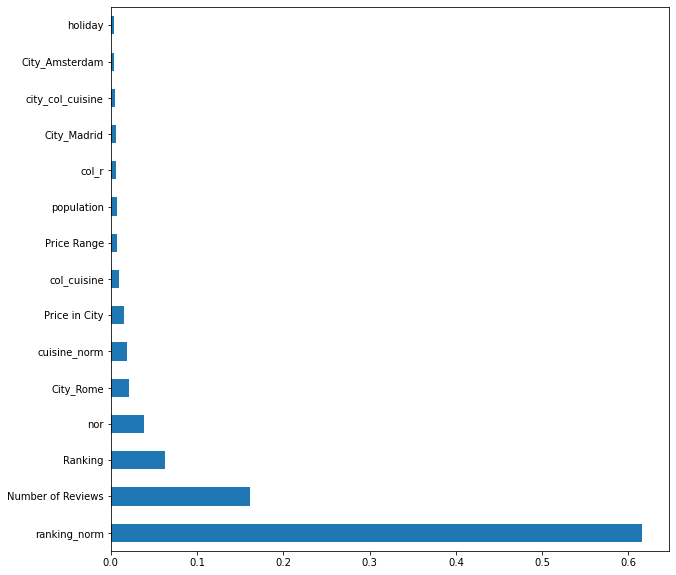

In [67]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [68]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,capital,population,Price in City,col_r,holiday,col_cuisine,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
5190,7755.0,2.0,29.0,0.0,1,2.148,1.926981,2,0.0,1,...,0,0,1,0,0,0,0,0,0,0
286,3287.0,2.0,4.0,0.0,1,0.506,1.822101,2,0.0,0,...,0,0,0,0,0,0,0,0,0,0
6107,3739.0,2.0,2.0,0.0,0,1.664,1.856259,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
635,7367.0,2.0,13.0,0.0,1,8.961,1.861949,2,0.0,1,...,0,0,0,0,0,0,0,0,0,0
5910,5008.0,2.0,73.0,0.0,1,2.148,1.926981,2,0.0,2,...,0,0,1,0,0,0,0,0,0,0
7166,1129.0,2.0,23.0,0.0,1,3.669,1.862477,2,0.0,3,...,0,0,0,0,0,0,0,0,0,0
519,2208.0,2.0,3.0,0.0,1,0.506,1.822101,2,0.0,5,...,0,0,0,0,0,0,0,0,0,0
920,1948.0,1.0,10.0,0.0,1,0.860,1.871720,2,0.0,2,...,0,0,0,0,0,0,0,0,0,0
6764,2463.0,2.0,13.0,0.0,1,1.335,1.840308,2,0.0,0,...,0,0,0,1,0,0,0,0,0,0
3614,6655.0,2.0,21.0,0.0,1,8.961,1.861949,2,0.0,2,...,0,0,0,0,0,0,0,0,0,0


In [69]:
test_data = test_data.drop(['Rating'], axis=1)

In [70]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [71]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [72]:
predict_submission

array([2.99 , 4.25 , 4.455, ..., 3.   , 4.49 , 4.38 ])

In [73]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.990
1,id_1,4.250
2,id_2,4.455
3,id_3,4.235
4,id_4,4.415
5,id_5,4.555
6,id_6,2.080
7,id_7,2.585
8,id_8,4.060
9,id_9,4.550


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
